In [1]:
!pip install openpyxl textdistance

You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../..")

import pandas as pd
import numpy as np
import seaborn as sns

import textdistance
from Levenshtein import distance, ratio
from fuzzywuzzy import fuzz

from hc_nlp.constants import ORG_LEGAL_SUFFIXES
from heritageconnector.nlp.nel import NELFeatureGenerator

# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

pd.options.display.max_rows = None

In [3]:
# df = pd.read_excel("../../../GITIGNORE_DATA/NEL/KD copy of review_data.xlsx 240221.xlsx")
df = pd.read_excel("../../../GITIGNORE_DATA/NEL/review_data_1103.xlsx", index_col=0)
df.loc[~df['link_correct'].isnull(), 'link_correct'] = df.loc[~df['link_correct'].isnull(), 'link_correct'].apply(int)
# df = df.drop(columns=["item_uri.1", "candidate_uri.1"])
df['ent_label'] = df['ent_label'].map({"PERSON": "PERSON", "OBJECT": "OBJECT", "ORG": "ORGANISATION"})
df['link_correct'] = df['link_correct'].map({0: False, 1: True})
df['_type_match'] = (df['ent_label'] == df['candidate_type'])
df[["ent_text", "candidate_title"]] = df[["ent_text", "candidate_title"]].astype(str)
df['_ent_candidate_distance'] = df.apply(lambda x: distance(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_similarity'] = df.apply(lambda x: ratio(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_sorted_similarity'] = df.apply(lambda x: fuzz.token_sort_ratio(x["ent_text"], x["candidate_title"])/100, axis=1)

df_annotated_not_in_search = df[df['candidate_rank'] == -1]
df_annotated = df[(~df['link_correct'].isnull()) & (df['candidate_rank'] != -1)]

len(df), len(df_annotated), len(df_annotated_not_in_search)

(5619, 1407, 8)

In [4]:
df_annotated.head()

,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity
0.0,https://collection.sciencemuseumgroup.org.uk/o...,0,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"British Railways came into existence, as the b...",Notice. British Railways (Southern Region). Ma...,True,0,1.000000,1.00
1.0,https://collection.sciencemuseumgroup.org.uk/o...,1,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,False,NaN,"Poster, British Railways poster (Waterlow & So...",Notice. British Railways (Southern Region). Ma...,False,0,1.000000,1.00
2.0,https://collection.sciencemuseumgroup.org.uk/o...,2,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,False,NaN,"Christmas card from James Ness, The Railway Ex...",Notice. British Railways (Southern Region). Ma...,False,0,1.000000,1.00
3.0,https://collection.sciencemuseumgroup.org.uk/o...,3,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,False,NaN,"Cap badge, BR (ScR), ""Lion on wheel"" device, w...",Notice. British Railways (Southern Region). Ma...,False,0,1.000000,1.00
4.0,https://collection.sciencemuseumgroup.org.uk/o...,4,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,"Worksplate, British Railways, ""British Railway...",OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,False,NaN,"Worksplate, British Railways, ""British Railway...",Notice. British Railways (Southern Region). Ma...,False,44,0.421053,0.44


## 1. Analysing annotations

In [5]:
print(f"Total number of true annotations: {sum(df_annotated.link_correct)}")
# print(f"Number of entity mentions with at least one true annotation: {(df_annotated.groupby(['item_uri', 'ent_text']).sum() > 0)['link_correct'].sum()}")

Total number of true annotations: 82


#### entity type

is entity type a good predictor of a match? -> **yes**

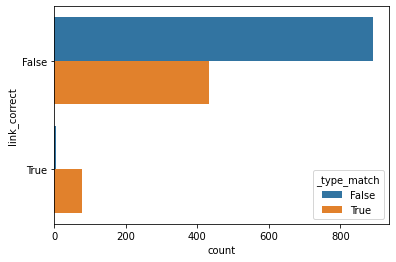

In [6]:
sns.countplot(y="link_correct", hue="_type_match", data=df_annotated);

### 1.1. Planning a Baseline predictor
1. Use **text similarity only** as a predictor of whether an entity mention maps to a SMG record.

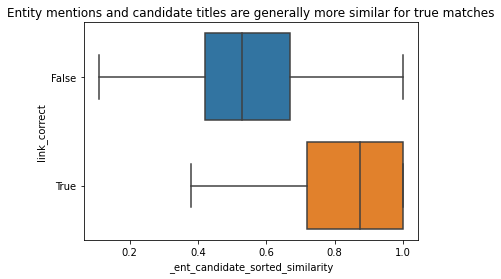

In [7]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", orient='h', showfliers=False)
g.set_title("Entity mentions and candidate titles are generally more similar for true matches");


2. Use **text similarity and matched type** as a predictor of whether an entity mention maps to an SMG record.

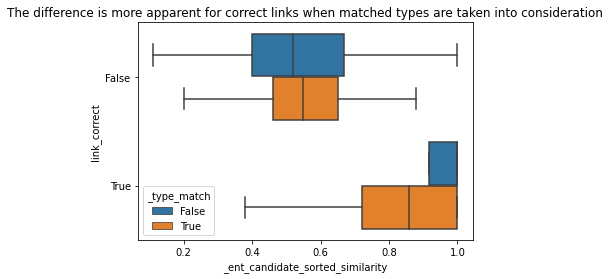

In [8]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)
g.set_title("The difference is more apparent for correct links when matched types are taken into consideration");

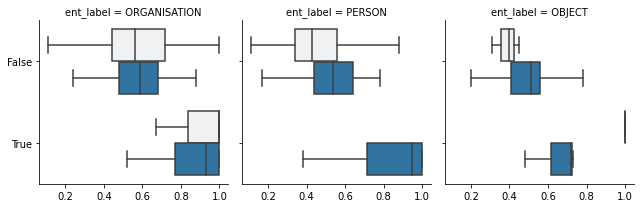

In [9]:
g = sns.FacetGrid(df_annotated, col="ent_label")
g.map_dataframe(sns.boxplot, data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)

## 2. Building a Baseline Predictor
- assume an entity mention and record are linked if `fuzz.token_sort_ratio(ent_mention, record_title)` is greater than a threshold, and the predicted entity mention type is the same as the record type
- set this threshold initially to 0.8 based on the above plot and then tune it for accuracy

In [10]:
threshold = 0.8
sim_metric_col = "_ent_candidate_sorted_similarity"

df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])

In [11]:
def calc_metrics(data, gt_col, pred_col):
    tp = len(data[data[gt_col] & data[pred_col]])
    fp = len(data[~data[gt_col] & data[pred_col]])
    tn = len(data[~data[gt_col] & ~data[pred_col]])
    fn = len(data[data[gt_col] & ~data[pred_col]])
    
    acc = (tp + tn) / (tp + fp + tn + fn)
    pr = tp / (tp + fp)
    re = tp / (tp + fn)
    f1 = (2 * pr * re) / (pr + re)
    
    return {"f1": f1, "precision": pr, "recall": re, "accuracy": acc}
    

print("OVERALL")
print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

for t in ["PERSON", "OBJECT", "ORGANISATION"]:
    print(t)
    print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

OVERALL
{'f1': 0.6293706293706294, 'precision': 0.7377049180327869, 'recall': 0.5487804878048781, 'accuracy': 0.9623312011371713}
PERSON
{'f1': 0.8148148148148148, 'precision': 1.0, 'recall': 0.6875, 'accuracy': 0.9874371859296482}
OBJECT
{'f1': 0.19354838709677416, 'precision': 0.3, 'recall': 0.14285714285714285, 'accuracy': 0.8226950354609929}
ORGANISATION
{'f1': 0.7294117647058822, 'precision': 0.775, 'recall': 0.6888888888888889, 'accuracy': 0.9735023041474654}


In [12]:
for threshold in (0.6, 0.7, 0.75, 0.8, 0.85):
    df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])
    
    print(f"--- {threshold} ---")
    print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

    for t in ["PERSON", "OBJECT", "ORGANISATION"]:
        print(t)
        print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

--- 0.6 ---
{'f1': 0.43870967741935485, 'precision': 0.2982456140350877, 'recall': 0.8292682926829268, 'accuracy': 0.8763326226012793}
PERSON
{'f1': 0.42424242424242425, 'precision': 0.28, 'recall': 0.875, 'accuracy': 0.9045226130653267}
OBJECT
{'f1': 0.5333333333333333, 'precision': 0.41025641025641024, 'recall': 0.7619047619047619, 'accuracy': 0.8014184397163121}
ORGANISATION
{'f1': 0.4130434782608696, 'precision': 0.2733812949640288, 'recall': 0.8444444444444444, 'accuracy': 0.8755760368663594}
--- 0.7 ---
{'f1': 0.6086956521739131, 'precision': 0.504, 'recall': 0.7682926829268293, 'accuracy': 0.9424307036247335}
PERSON
{'f1': 0.5853658536585366, 'precision': 0.48, 'recall': 0.75, 'accuracy': 0.957286432160804}
OBJECT
{'f1': 0.5957446808510638, 'precision': 0.5384615384615384, 'recall': 0.6666666666666666, 'accuracy': 0.8652482269503546}
ORGANISATION
{'f1': 0.6218487394957983, 'precision': 0.5, 'recall': 0.8222222222222222, 'accuracy': 0.9481566820276498}
--- 0.75 ---
{'f1': 0.56626

## 3. Building a machine learning predictor
Using only the mention, title, and types of each.

In [13]:
f = NELFeatureGenerator(df_annotated, 
                     ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
                     candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X = f.get_feature_matrix()
y = f.get_target_vector('link_correct')
# y = 1*(df_annotated['link_correct'].values)

2021-03-16 17:21:10,343 - heritageconnector.nlp.nel - INFO - Calculating entity context sBERT embeddings... (1/2)


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

2021-03-16 17:21:50,380 - heritageconnector.nlp.nel - INFO - Calculating candidate context sBERT embeddings... (2/2)


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

In [14]:
f.get_feature_names()

['fuzz_sort similarity (mention-title)',
 'levenshtein similarity (mention-title)',
 'jaro-winkler similarity (mention-title)',
 'fuzz_sort similarity, ignoring suffixes (mention-title)',
 'jaro-winkler similarity (context-context)',
 'jaccard similarity (context-context)',
 'sorensen-dice similarity (context-context)',
 'label is in mention',
 'mention is in label',
 'entity type (OBJECT)',
 'entity type (ORGANISATION)',
 'entity type (PERSON)',
 'candidate type (OBJECT)',
 'candidate type (ORGANISATION)',
 'candidate type (PERSON)',
 'sBERT embedding cosine similarity (context-context)']

In [15]:
X.shape, len(y)

((1407, 16), 1407)

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier

def test_classifiers(X, y):
    all_scores = {}
    
    # SVM
    svm = SVC(random_state=0, kernel='linear', probability=True)
    scores = cross_validate(svm, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['SVM'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    # logistic regression
    log_r = LogisticRegressionCV(cv=5, random_state=0, max_iter=500).fit(X, list(y))

    scores = cross_validate(log_r, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['logr'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    # MLP    
    mlp = MLPClassifier(random_state=0, max_iter=1000)

    scores = cross_validate(mlp, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['MLP'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    return (svm, log_r, mlp), all_scores

(svm, log_r, mlp), scores = test_classifiers(X, y)
scores

{'SVM': ((0.8857560247204266, 0.0951702740977622),
  (0.7658715918584338, 0.09557413141585487)),
 'logr': ((0.9010077639628351, 0.09941743355565327),
  (0.7891096111490847, 0.07151490089875455)),
 'MLP': ((0.8822290922322402, 0.1012641819702522),
  (0.82295653907496, 0.07735641577194291))}

### 3.1 Test on unannotated data

In [17]:
df_unannotated = df[df['link_correct'].isnull()]
len(df_unannotated)

4204

In [19]:
f_un = NELFeatureGenerator(df_unannotated, 
                     ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
                     candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X_un = f_un.get_feature_matrix()

X_un.shape

2021-03-16 17:23:11,540 - heritageconnector.nlp.nel - INFO - Calculating entity context sBERT embeddings... (1/2)


Batches:   0%|          | 0/132 [00:00<?, ?it/s]

2021-03-16 17:25:29,428 - heritageconnector.nlp.nel - INFO - Calculating candidate context sBERT embeddings... (2/2)


Batches:   0%|          | 0/132 [00:00<?, ?it/s]

(4204, 16)

In [20]:
classifier = mlp.fit(X, y)

# feature importance if classifier is an SVM with a linear kernel
# print([(idx, coef**2) for idx,coef in enumerate(list(classifier.coef_[0]))])

df_unannotated['log_r_prediction'] = classifier.predict(X_un)
df_unannotated['log_r_prediction_proba'] = classifier.predict_proba(X_un)[:,1]

df_unannotated[df_unannotated['log_r_prediction'] == 1].head(100).sort_values("log_r_prediction_proba", ascending=False)



,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,log_r_prediction,log_r_prediction_proba
2997.0,https://collection.sciencemuseumgroup.org.uk/o...,0,"Coffee cup, ceramic, Great Central Railway - G...",OBJECT,Spode,"Coffee cup, ceramic, Great Central Railway - G...",Spode,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Manufacturer of ceramics, porcelain, Parian wa...","Coffee cup, ceramic, Great Central Railway - G...",False,0,1.000000,1.00,1,0.982972
2998.0,https://collection.sciencemuseumgroup.org.uk/o...,1,"Coffee cup, ceramic, Great Central Railway - G...",OBJECT,Spode,"Coffee cup, ceramic, Great Central Railway - G...",Spode Limited,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Manufacturer of ceramics, porcelain, Parian wa...","Coffee cup, ceramic, Great Central Railway - G...",False,8,0.555556,0.56,1,0.971936
1879.0,https://collection.sciencemuseumgroup.org.uk/p...,5,"Clifton, G.,'Directory of British Scientific I...",PERSON,George Knight,Name used before & after death of George Knigh...,"Knight, George",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Clifton, G., 'Directory of British Scientific ...","Clifton, G.,'Directory of British Scientific I...",True,13,0.444444,1.00,1,0.960428
2877.0,https://collection.sciencemuseumgroup.org.uk/o...,0,A black and white silver gelatin photograph en...,PERSON,Kurt Hutton,"By Kurt Hutton, taken in 1946.","Hutton, Kurt",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,19 March 2014 Photographer and photojourn...,A black and white silver gelatin photograph en...,True,9,0.521739,1.00,1,0.954953
2342.0,https://collection.sciencemuseumgroup.org.uk/o...,0,"Movement board for the electric clock, by [[Al...",PERSON,Alexander Bain,"Movement board for the electric clock, by Alex...","Bain, Alexander",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"R. W. Burns, ‘Bain, Alexander (1810–1877)’, , ...","Movement board for the electric clock, by Alex...",True,11,0.620690,1.00,1,0.953851
2612.0,https://collection.sciencemuseumgroup.org.uk/o...,0,"Townley's inhaler for chloroform anaesthesia, ...",ORGANISATION,Arnold and Sons,"Townley's inhaler for chloroform anaesthesia, ...",Arnold and Sons,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"1819 - J. & S. Arnold, 59 Barbican, chemist an...","Townley's inhaler for chloroform anaesthesia, ...",True,0,1.000000,1.00,1,0.952437
2867.0,https://collection.sciencemuseumgroup.org.uk/o...,0,"Siemens valve, type 15A, marked CV986, (RMW/Y5...",ORGANISATION,Siemens,"Siemens valve, type 15A, marked CV986, (RMW/Y5...",Siemens,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,1847 - founded by Werner von Siemens and Johan...,"Siemens valve, type 15A, marked CV986, (RMW/Y5...",True,0,1.000000,1.00,1,0.951945
2852.0,https://collection.sciencemuseumgroup.org.uk/o...,0,"[[Siemens]] valve, type 15A, marked CV986, (RM...",ORGANISATION,Siemens,"Siemens valve, type 15A, marked CV986, (RMW/Y5...",Siemens,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,1847 - founded by Werner von Siemens and Johan...,"Siemens valve, type 15A, marked CV986, (RMW/Y5...",True,0,1.000000,1.00,1,0.951945
2562.0,https://collection.sciencemuseumgroup.org.uk/o...,0,[[British Nuclear Fuels Limited]] dummy Windsc...,ORGANISATION,British Nuclear Fuels Limited,British Nuclear Fuels Limited dummy Windscale ...,British Nuclear Fuels Limited,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,; 1971 - British Nuclear Fuels Limited ...,British Nuclear Fuels Limited dummy Windscale ...,True,0,1.000000,1.00,1,0.949891
2563.0,https://collection.sciencemuseumgroup.org.uk/o...,1,[[British N

### 3.2 What about rows that didn't make the top *n* search results?

*Performance is not great*, but there are only 8 samples. This can be fixed by boosting the correct type in the search results.

In [22]:
# add [object,object] row onto end as it doesn't exist in the original data
df_newrows = df_annotated_not_in_search.append(df_annotated.loc[(df_annotated["ent_label"] == "OBJECT") & (df_annotated["candidate_type"] == "OBJECT")].iloc[0])

f = NELFeatureGenerator(df_newrows, 
                     ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
                     candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X_missed = f.get_feature_matrix()
y_missed = f.get_target_vector('link_correct')


2021-03-16 17:28:49,142 - heritageconnector.nlp.nel - INFO - Calculating entity context sBERT embeddings... (1/2)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-16 17:28:49,733 - heritageconnector.nlp.nel - INFO - Calculating candidate context sBERT embeddings... (2/2)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
svm = svm.fit(X,y)

df_annotated_not_in_search['pred'] = svm.predict(X_missed)[0:-1]
df_annotated_not_in_search['pred_proba'] = svm.predict_proba(X_missed)[:-1,1]

df_annotated_not_in_search

,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,pred,pred_proba
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,Graduated mercury thermometer used by [[James ...,PERSON,James Joule,NaN,James Prescott Joule,PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"1818-1889, physicist, English, British",Graduated mercury thermometer used by James Jo...,True,9,0.709677,0.71,0,0.142610
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"Royal Coat of Arms, [[Great Northern Railway]]...",ORGANISATION,Great Northern Railway,NaN,Great Northern Railway,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,Established in the 1846 London and York Railwa...,"Royal Coat of Arms, Great Northern Railway. Fr...",True,0,1.000000,1.00,1,0.873571
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"'England by the Sea' maquette, made by [[Tony ...",PERSON,Tony Ray-Jones,NaN,"Ray-Jones, Tony",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,Freelance photographer working in London and A...,"'England by the Sea' maquette, made by Tony Ra...",True,11,0.620690,1.00,0,0.486240
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"'England by the Sea' maquette, made by Tony Ra...",PERSON,Tony Ray-Jones,NaN,"Ray-Jones, Tony",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,Freelance photographer working in London and A...,"'England by the Sea' maquette, made by Tony Ra...",True,11,0.620690,1.00,0,0.486240
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"Pen and ink, watercolour and carriage oils on ...",ORGANISATION,Barker & Co.,NaN,Barker and Company Limited,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"Barker and Company, Coachbuilders, 1710-1938 ...","Pen and ink, watercolour and carriage oils on ...",True,16,0.526316,0.51,0,0.063424
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,Leaflet. Reproduction timetable leaflet produ...,ORGANISATION,the Southern Railway,NaN,Southern Railway,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"The Southern Railway in the United Kingdom, wh...",Leaflet. Reproduction timetable leaflet produ...,True,4,0.888889,0.89,1,0.837942
NaN,https://collection.sciencemuseumgroup.org.uk/p...,-1,Simpson became Physician to [[Queen Victoria]]...,PERSON,Queen Victoria,NaN,Victoria,PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,1837 - succeeded King William IV upon his death.,Simpson became Physician to Queen Victoria in ...,True,6,0.727273,0.73,0,0.411098
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"[[Spencer Wells]] artery forceps, screw-joint,...",PERSON,Spencer Wells,NaN,"Wells, Sir Thomas Spencer",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"ane Eliot Sewell, ‘Wells, Sir Thomas Spencer, ...","Spencer Wells artery forceps, screw-joint, pla...",True,22,0.368421,0.70,0,0.236431
